# <a id="0">Содержание</a>

- <a href="#1">Импорт необходимых библиотек</a>
- <a href="#2">Чтение и подготовка данных</a>
- <a href="#3">Подбор параметров на различных метриках качества</a>
    - <a href="#31">MSE</a>
    - <a href="#32">MAE</a>
    - <a href="#33">SMLAR</a>
- <a href="#4">Обучение моделей регрессии</a>  
    - <a href="#41">LightGBM</a>
    - <a href="#42">CatBoost</a>
    - <a href="#43">XGBoost</a>
    - <a href="#44">Сравнение моделей</a>

## <a id="1">Импорт необходимых библиотек</a>

In [9]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import pickle
import time
from math import exp

import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

import matplotlib.pyplot as plt
import seaborn as sns
import shap

import warnings
warnings.filterwarnings('ignore')

## <a id="2">Чтение и подготовка данных</a>

In [2]:
# Чтение файла
df = pd.read_csv('../feature_engeniting/data_to_train.csv')

# Чтение при обучении из google colab
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_to_train.csv')

# Предпросмотр данных
df.head()

,count,publisher_1,publisher_10,publisher_11,publisher_12,publisher_13,publisher_14,publisher_15,publisher_16,publisher_17,...,city_17,city_19,city_201,city_21,city_25,city_3,city_60,city_7,city_8,city_other
0,23,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,6,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [3]:
# Знакомство с данными
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495001 entries, 0 to 495000
Data columns (total 66 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   count                495001 non-null  int64  
 1   publisher_1          495001 non-null  int64  
 2   publisher_10         495001 non-null  int64  
 3   publisher_11         495001 non-null  int64  
 4   publisher_12         495001 non-null  int64  
 5   publisher_13         495001 non-null  int64  
 6   publisher_14         495001 non-null  int64  
 7   publisher_15         495001 non-null  int64  
 8   publisher_16         495001 non-null  int64  
 9   publisher_17         495001 non-null  int64  
 10  publisher_18         495001 non-null  int64  
 11  publisher_19         495001 non-null  int64  
 12  publisher_2          495001 non-null  int64  
 13  publisher_20         495001 non-null  int64  
 14  publisher_21         495001 non-null  int64  
 15  publisher_3      

In [4]:
# Посмотрим на столбец city_group, имеющий тип object
df['city_group'].value_counts()

city_group
other    249317
0        141684
3         35444
7         22418
25         5709
19         5472
60         5462
8          4855
201        4570
21         4377
17         3939
Name: count, dtype: int64

In [5]:
# Выделим таргет и удалим столбец city_group, сотавшиймя после предобработки
X = df.drop(['count', 'city_group'], axis=1)
y = df['count']

# Разобьем выборки на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Стандартизируем данные
sc = StandardScaler()
sc.fit(X_train)
X_train_sc=sc.transform(X_train)
X_test_sc=sc.transform(X_test)

Text(0.5, 1.0, 'Распределение таргетов')

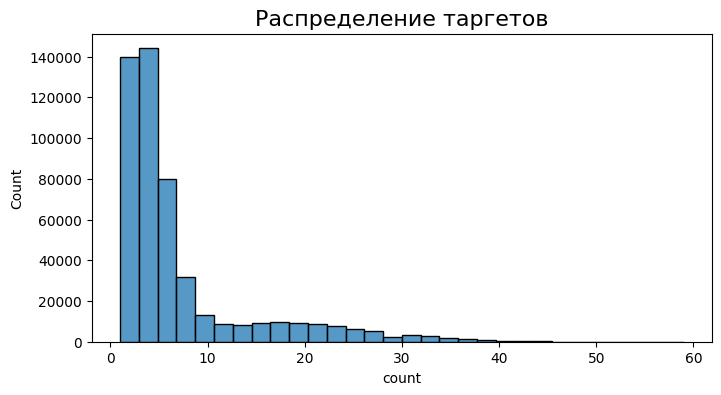

In [7]:
fig = plt.figure(figsize=(8, 4))
histplot = sns.histplot(
    data=df,
    x='count',
    bins=30,
    #kde=True,
)
histplot.set_title('Распределение таргетов', fontsize=16)

## <a id="3">Тестовое обучение на различных метриках качества</a>

### <a id="31">MSE</a>

In [14]:
# Функция расчета метрики Smoothed Mean Log Accuracy Ratio
def smlar(y, y_pred, e=0.005):
    return exp(np.sum(abs(np.log((abs(y_pred) + e)/(y + e))))/len(y)) - 1

In [12]:
def objective_lgbm_reg(trial):
    # Подбираемые параметры
    params={'verbose':-1,
            "objective": "regression",
            'lambda_l2':trial.suggest_float('lambda_l2', 0.1, 1),
            'max_depth':trial.suggest_int('max_depth', 5, 100),
            'num_leaves':trial.suggest_int('num_leaves', 5, 105, step=10),
            'learning_rate':trial.suggest_float('learning_rate',0.001, 0.901, step=0.01),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.8 , step=0.1)
            }

    # Обучаем модель
    optuna_model = LGBMRegressor(**params)
    optuna_model.fit(X_train_sc, y_train)

    # Предсказание
    y_pred = optuna_model.predict(X_test_sc)

    # Оценка предсказания
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Создаем сессию для минимизации выбранной метрики
study_lgbm_reg = optuna.create_study(direction='minimize')
# Запускаем нашу сессию оптимизации
study_lgbm_reg.optimize(objective_lgbm_reg, n_trials=30)

[I 2024-12-16 13:04:55,313] A new study created in memory with name: no-name-a942e43f-1bf0-49a9-a07d-8bfa58476816
[I 2024-12-16 13:05:03,959] Trial 0 finished with value: 6.859259369261886 and parameters: {'lambda_l2': 0.20160210929902067, 'max_depth': 87, 'num_leaves': 25, 'learning_rate': 0.211, 'bagging_fraction': 0.7}. Best is trial 0 with value: 6.859259369261886.
[I 2024-12-16 13:05:09,878] Trial 1 finished with value: 6.635452441309741 and parameters: {'lambda_l2': 0.9430785889400436, 'max_depth': 74, 'num_leaves': 45, 'learning_rate': 0.811, 'bagging_fraction': 0.6}. Best is trial 1 with value: 6.635452441309741.
[I 2024-12-16 13:05:17,801] Trial 2 finished with value: 6.385491698028007 and parameters: {'lambda_l2': 0.9618675095064305, 'max_depth': 49, 'num_leaves': 65, 'learning_rate': 0.501, 'bagging_fraction': 0.8}. Best is trial 2 with value: 6.385491698028007.
[I 2024-12-16 13:05:24,247] Trial 3 finished with value: 6.447663629331904 and parameters: {'lambda_l2': 0.2421136

In [15]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_lgbm_reg.trials)))
print('Лучший трайл:')
trial = study_lgbm_reg.best_trial

print('  Лучший MSE: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 30
Лучший трайл:
  Лучший MSE: 6.192710231005644
  Параметры: 
    lambda_l2: 0.7705086238379468
    max_depth: 41
    num_leaves: 95
    learning_rate: 0.451
    bagging_fraction: 0.7


In [17]:
# Обучим модель на получившихся параметрах
params = trial.params
lgbm_reg = LGBMRegressor(verbose=-1,**params)
lgbm_reg.fit(X_train_sc, y_train)

# Предсказание
y_pred_lgbm_reg = lgbm_reg.predict(X_test_sc)

# Считаем основные метрики
smlar_lgbm = smlar(y_test, y_pred_lgbm_reg)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm_reg)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm_reg)
r2_lgbm = r2_score(y_test, y_pred_lgbm_reg)

# Выводим основные метрики
print(f"SMLAR LightGBM: {smlar_lgbm * 100 :.2f}%")
print(f"MAE LightGBM: {mae_lgbm:.3f}")
print(f"MSE LightGBM: {mse_lgbm:.3f}")
print(f"R2_score LightGBM: {r2_lgbm * 100 :.2f}%")

SMLAR LightGBM: 43.45%
MAE LightGBM: 1.709
MSE LightGBM: 6.193
R2_score LightGBM: 89.04%


### <a id="32">MAE</a>

In [18]:
def objective_lgbm_reg(trial):
    # Подбираемые параметры
    params={'verbosity':-1,
            "objective": "regression",
            'lambda_l2':trial.suggest_float('lambda_l2', 0.1, 1),
            'max_depth':trial.suggest_int('max_depth', 5, 100),
            'num_leaves':trial.suggest_int('num_leaves', 5, 105, step=10),
            'learning_rate':trial.suggest_float('learning_rate',0.001, 0.901, step=0.01),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.8 , step=0.1)
            }

    # Обучаем модель
    optuna_model = LGBMRegressor(**params)
    optuna_model.fit(X_train_sc, y_train)

    # Предсказание
    y_pred = optuna_model.predict(X_test_sc)

    # Оценка предсказания
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# Создаем сессию для минимизации выбранной метрики
study_lgbm_reg = optuna.create_study(direction='minimize')
# Запускаем нашу сессию оптимизации
study_lgbm_reg.optimize(objective_lgbm_reg, n_trials=30)

[I 2024-12-16 13:12:11,370] A new study created in memory with name: no-name-0cb906a0-a605-4756-97ae-bcd4158273a7
[I 2024-12-16 13:12:19,620] Trial 0 finished with value: 1.74654064920472 and parameters: {'lambda_l2': 0.5336358941725273, 'max_depth': 15, 'num_leaves': 105, 'learning_rate': 0.761, 'bagging_fraction': 0.5}. Best is trial 0 with value: 1.74654064920472.
[I 2024-12-16 13:12:31,600] Trial 1 finished with value: 1.7485756270567323 and parameters: {'lambda_l2': 0.53333432999446, 'max_depth': 95, 'num_leaves': 95, 'learning_rate': 0.131, 'bagging_fraction': 0.8}. Best is trial 0 with value: 1.74654064920472.
[I 2024-12-16 13:12:39,079] Trial 2 finished with value: 1.780012914603454 and parameters: {'lambda_l2': 0.7728877927788398, 'max_depth': 85, 'num_leaves': 35, 'learning_rate': 0.851, 'bagging_fraction': 0.8}. Best is trial 0 with value: 1.74654064920472.
[I 2024-12-16 13:12:53,283] Trial 3 finished with value: 1.8043889195543377 and parameters: {'lambda_l2': 0.84228826852

In [19]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_lgbm_reg.trials)))
print('Лучший трайл:')
trial = study_lgbm_reg.best_trial

print('  Лучший MAE: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 30
Лучший трайл:
  Лучший MAE: 1.7027127783703286
  Параметры: 
    lambda_l2: 0.5225355274732298
    max_depth: 23
    num_leaves: 105
    learning_rate: 0.341
    bagging_fraction: 0.5


In [20]:
# Обучим модель на получившихся параметрах
params = trial.params
lgbm_reg = LGBMRegressor(verbose=-1,**params)
lgbm_reg.fit(X_train_sc, y_train)

# Предсказание
y_pred_lgbm_reg = lgbm_reg.predict(X_test_sc)

# Считаем основные метрики
smlar_lgbm = smlar(y_test, y_pred_lgbm_reg)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm_reg)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm_reg)
r2_lgbm = r2_score(y_test, y_pred_lgbm_reg)

# Выводим основные метрики
print(f"SMLAR LightGBM: {smlar_lgbm * 100 :.2f}%")
print(f"MAE LightGBM: {mae_lgbm:.3f}")
print(f"MSE LightGBM: {mse_lgbm:.3f}")
print(f"R2_score LightGBM: {r2_lgbm * 100 :.2f}%")

SMLAR LightGBM: 43.01%
MAE LightGBM: 1.703
MSE LightGBM: 6.163
R2_score LightGBM: 89.09%


### <a id="33">SMLAR</a>

In [21]:
def objective_lgbm_reg(trial):
    # Подбираемые параметры
    params={'verbose':-1,
            "objective": "regression",
            'lambda_l2':trial.suggest_float('lambda_l2', 0.1, 1),
            'max_depth':trial.suggest_int('max_depth', 5, 100),
            'num_leaves':trial.suggest_int('num_leaves', 5, 105, step=10),
            'learning_rate':trial.suggest_float('learning_rate',0.001, 0.901, step=0.01),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.8 , step=0.1)
            }

    # Обучаем модель
    optuna_model = LGBMRegressor(**params)
    optuna_model.fit(X_train_sc, y_train)

    # Предсказание
    y_pred = optuna_model.predict(X_test_sc)

    # Оценка предсказания
    smlar_lgbm = smlar(y_test, y_pred)
    return smlar_lgbm

# Создаем сессию для минимизации выбранной метрики
study_lgbm_reg = optuna.create_study(direction='minimize')
# Запускаем нашу сессию оптимизации
study_lgbm_reg.optimize(objective_lgbm_reg, n_trials=30)

[I 2024-12-16 13:16:37,445] A new study created in memory with name: no-name-3049f613-38db-4dab-adbf-fcb87f5478d5
[I 2024-12-16 13:16:44,647] Trial 0 finished with value: 0.44597405828188785 and parameters: {'lambda_l2': 0.9342648791809987, 'max_depth': 70, 'num_leaves': 35, 'learning_rate': 0.441, 'bagging_fraction': 0.8}. Best is trial 0 with value: 0.44597405828188785.
[I 2024-12-16 13:16:51,265] Trial 1 finished with value: 0.4400382002542358 and parameters: {'lambda_l2': 0.3500102029195227, 'max_depth': 35, 'num_leaves': 65, 'learning_rate': 0.581, 'bagging_fraction': 0.5}. Best is trial 1 with value: 0.4400382002542358.
[I 2024-12-16 13:16:59,824] Trial 2 finished with value: 0.443646601243161 and parameters: {'lambda_l2': 0.8082886658514539, 'max_depth': 83, 'num_leaves': 55, 'learning_rate': 0.221, 'bagging_fraction': 0.7}. Best is trial 1 with value: 0.4400382002542358.
[I 2024-12-16 13:17:06,628] Trial 3 finished with value: 0.4331791730427048 and parameters: {'lambda_l2': 0.

In [22]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_lgbm_reg.trials)))
print('Лучший трайл:')
trial = study_lgbm_reg.best_trial

print('  Лучший SMLAR: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 30
Лучший трайл:
  Лучший SMLAR: 0.43105649700998616
  Параметры: 
    lambda_l2: 0.23537559345169096
    max_depth: 98
    num_leaves: 105
    learning_rate: 0.401
    bagging_fraction: 0.8


In [23]:
# Обучим модель на получившихся параметрах
params = trial.params
lgbm_reg = LGBMRegressor(verbose=-1,**params)
lgbm_reg.fit(X_train_sc, y_train)

# Предсказание
y_pred_lgbm_reg = lgbm_reg.predict(X_test_sc)

# Считаем основные метрики
smlar_lgbm = smlar(y_test, y_pred_lgbm_reg)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm_reg)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm_reg)
r2_lgbm = r2_score(y_test, y_pred_lgbm_reg)

# Выводим основные метрики
print(f"SMLAR LightGBM: {smlar_lgbm * 100 :.2f}%")
print(f"MAE LightGBM: {mae_lgbm:.3f}")
print(f"MSE LightGBM: {mse_lgbm:.3f}")
print(f"R2_score LightGBM: {r2_lgbm * 100 :.2f}%")

SMLAR LightGBM: 43.11%
MAE LightGBM: 1.707
MSE LightGBM: 6.231
R2_score LightGBM: 88.97%


## <a id="4">Обучение моделей регрессии</a>

### <a id="41">LightGBM</a>

In [10]:
def objective_lgbm_reg(trial):
    # Подбираемые параметры
    params={'verbose':-1,
            "objective": "regression",
            'lambda_l2':trial.suggest_float('lambda_l2', 0.1, 1),
            'max_depth':trial.suggest_int('max_depth', 5, 100),
            'num_leaves':trial.suggest_int('num_leaves', 5, 105, step=10),
            'learning_rate':trial.suggest_float('learning_rate',0.001, 0.901, step=0.01),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.8 , step=0.1)
            }

    # Обучаем модель
    optuna_model = LGBMRegressor(**params)
    optuna_model.fit(X_train_sc, y_train)

    # Предсказание
    y_pred = optuna_model.predict(X_test_sc)

    # Оценка предсказания
    mae_lgbm = mean_absolute_error(y_test, y_pred)
    return mae_lgbm

# Создаем сессию для минимизации выбранной метрики
study_lgbm_reg = optuna.create_study(direction='minimize')
# Запускаем нашу сессию оптимизации
study_lgbm_reg.optimize(objective_lgbm_reg, n_trials=100)

[I 2024-12-16 23:18:09,847] A new study created in memory with name: no-name-759d2328-0128-4003-acf7-e8753037c18f
[I 2024-12-16 23:18:15,526] Trial 0 finished with value: 1.727698570907867 and parameters: {'lambda_l2': 0.24576494121962925, 'max_depth': 83, 'num_leaves': 95, 'learning_rate': 0.191, 'bagging_fraction': 0.6}. Best is trial 0 with value: 1.727698570907867.
[I 2024-12-16 23:18:19,855] Trial 1 finished with value: 1.7605723599721776 and parameters: {'lambda_l2': 0.9860032034357656, 'max_depth': 9, 'num_leaves': 45, 'learning_rate': 0.271, 'bagging_fraction': 0.8}. Best is trial 0 with value: 1.727698570907867.
[I 2024-12-16 23:18:23,753] Trial 2 finished with value: 1.777863237609458 and parameters: {'lambda_l2': 0.41371618726890036, 'max_depth': 44, 'num_leaves': 25, 'learning_rate': 0.791, 'bagging_fraction': 0.8}. Best is trial 0 with value: 1.727698570907867.
[I 2024-12-16 23:18:29,084] Trial 3 finished with value: 1.7720878748814444 and parameters: {'lambda_l2': 0.19379

<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

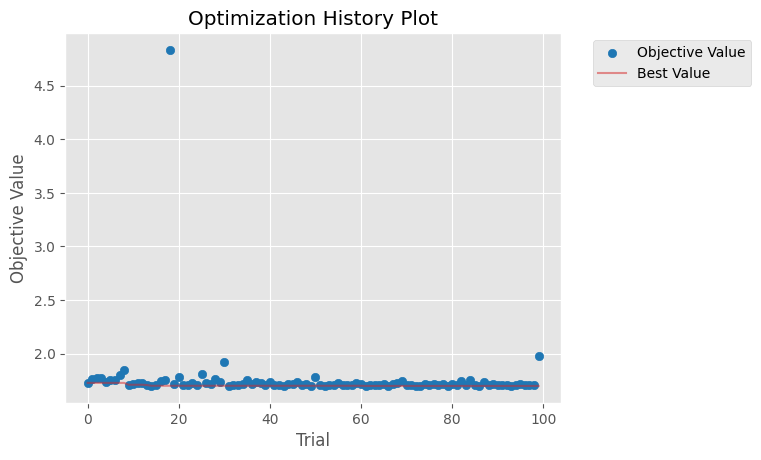

In [11]:
# Посмотрим на процесс подбора параметров на графике
plot_optimization_history(study_lgbm_reg)

In [12]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_lgbm_reg.trials)))
print('Лучший трайл:')
trial = study_lgbm_reg.best_trial

print('  Лучший MAE: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 100
Лучший трайл:
  Лучший MAE: 1.6994123014562479
  Параметры: 
    lambda_l2: 0.7267716739981885
    max_depth: 87
    num_leaves: 105
    learning_rate: 0.341
    bagging_fraction: 0.8


In [15]:
# Засечем время, которое алгоритму потребуется на обучение
start_time = time.time()

# Обучим модель на получившихся параметрах
params = trial.params
lgbm_reg = LGBMRegressor(verbose=-1,**params)
lgbm_reg.fit(X_train_sc, y_train)

# Предсказание
y_pred_lgbm_reg = lgbm_reg.predict(X_test_sc)

# Конец временного промежутка
lgbm_reg_time = time.time() - start_time

# Считаем основные метрики
smlar_lgbm = smlar(y_test, y_pred_lgbm_reg)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm_reg)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm_reg)
r2_lgbm = r2_score(y_test, y_pred_lgbm_reg)

# Выводим основные метрики
print(f"SMLAR LightGBM: {smlar_lgbm * 100 :.2f}%")
print(f"MAE LightGBM: {mae_lgbm:.3f}")
print(f"MSE LightGBM: {mse_lgbm:.3f}")
print(f"R2_score LightGBM: {r2_lgbm * 100 :.2f}%")
print(f"Время обучения LightGBM: {lgbm_reg_time:.2f} сек")

SMLAR LightGBM: 42.92%
MAE LightGBM: 1.699
MSE LightGBM: 6.154
R2_score LightGBM: 89.11%
Время обучения LightGBM: 4.80 сек


In [16]:
# вычисление SHAP-значений
explainer_lgbm = shap.Explainer(lgbm_reg)
shap_values_lgbm = explainer_lgbm(X_test)

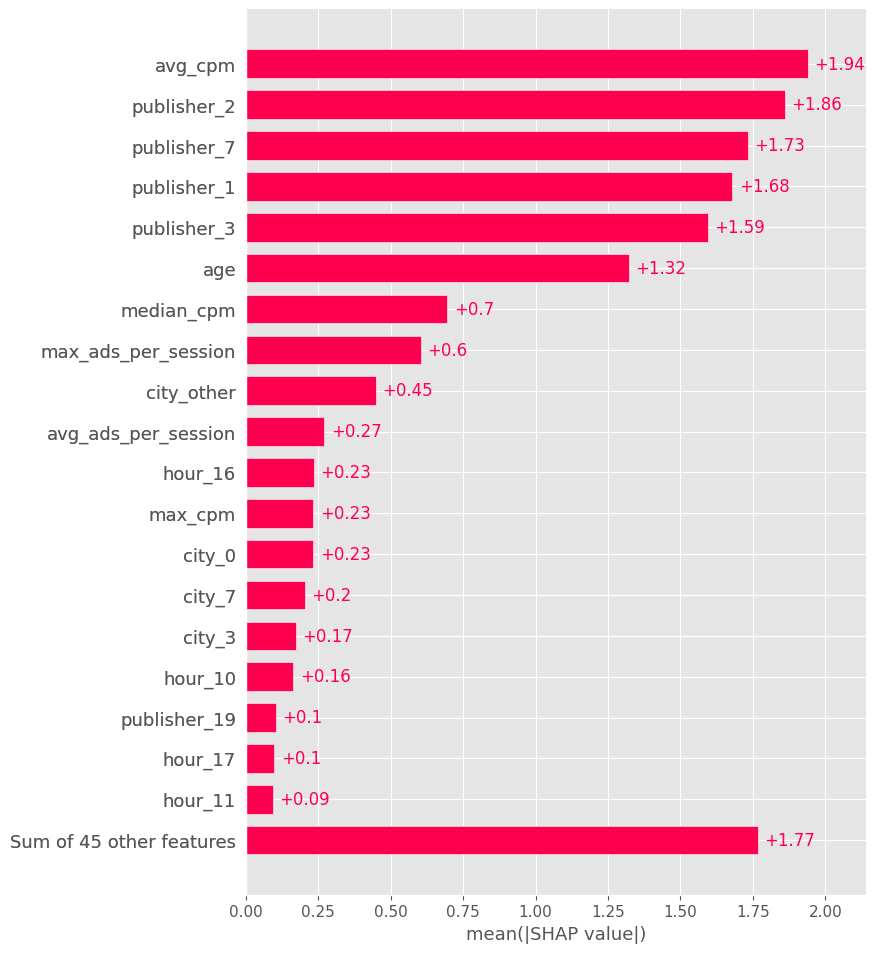

In [17]:
# определение признаков, являющихся наиболее важными для прогнозов
shap.plots.bar(shap_values_lgbm, max_display=20)

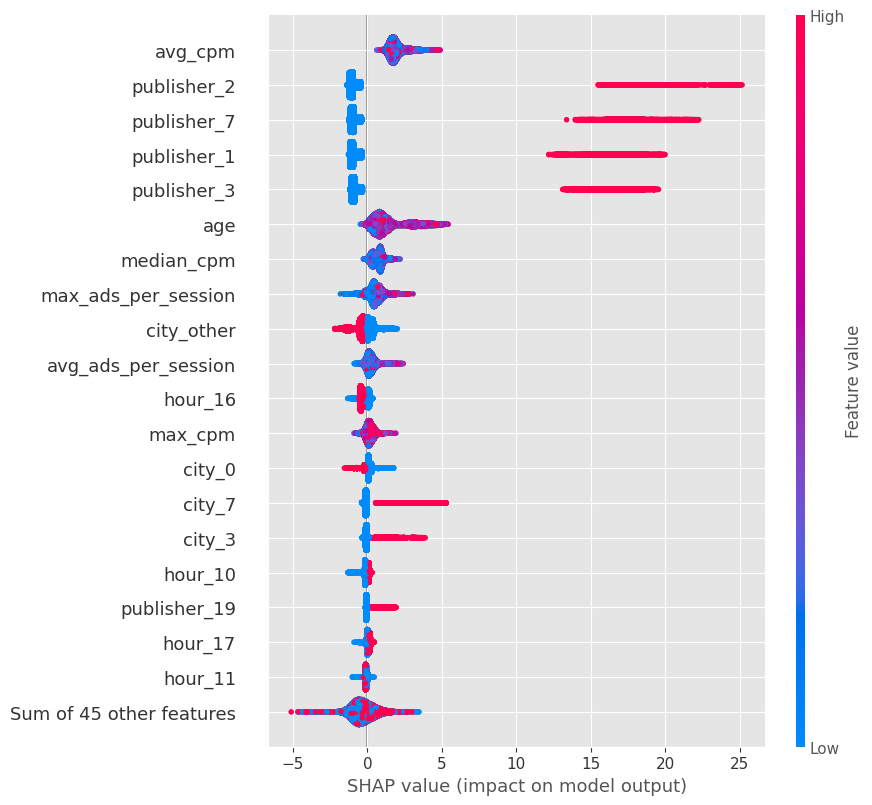

In [18]:
# визуализация всех SHAP‑значений для признаков
shap.plots.beeswarm(shap_values_lgbm, max_display=20)

In [19]:
# Сохраним модель
with open(r'models/lgbm_model.pkl', 'wb') as file:
    pickle.dump(lgbm_reg, file)
    
# Сохранение для google colab
# with open(r'/content/drive/MyDrive/Colab Notebooks/models/lgbm_model.pkl', 'wb') as file:
#     pickle.dump(lgbm_reg, file)

### <a id="42">CatBoost</a>

In [20]:
def objective_catb_reg(trial):
    # Подбираемые параметры
    params={
        'iterations': trial.suggest_int("iterations", 100, 1000),
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'depth': trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        'random_strength': trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        'bagging_temperature': trial.suggest_float("bagging_temperature", 0.0, 10.0),
        'od_type': trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait': trial.suggest_int("od_wait", 10, 50),
        'verbose': 0,
    }

    # Обучаем модель
    optuna_model = CatBoostRegressor(**params)
    optuna_model.fit(X_train_sc, y_train)

    # Предсказание
    y_pred = optuna_model.predict(X_test_sc)

    # Оценка предсказания
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# Создаем сессию для минимизации выбранной метрики
study_catb_reg = optuna.create_study(direction='minimize')
# Запускаем нашу сессию оптимизации
study_catb_reg.optimize(objective_catb_reg, n_trials=100)

[I 2024-12-16 23:31:55,259] A new study created in memory with name: no-name-ff6e88a6-6b4a-4d01-aa83-1950178d318d
[I 2024-12-16 23:32:35,279] Trial 0 finished with value: 2.165137380070639 and parameters: {'iterations': 491, 'learning_rate': 0.0051004674999763355, 'depth': 8, 'l2_leaf_reg': 0.9570637878037229, 'random_strength': 8.42273927490998e-07, 'bagging_temperature': 0.34672726440682644, 'od_type': 'Iter', 'od_wait': 39}. Best is trial 0 with value: 2.165137380070639.
[I 2024-12-16 23:32:43,794] Trial 1 finished with value: 4.486726266670092 and parameters: {'iterations': 188, 'learning_rate': 0.001080916117029068, 'depth': 4, 'l2_leaf_reg': 13.956472997708389, 'random_strength': 1.048549732209117e-08, 'bagging_temperature': 4.272181665966519, 'od_type': 'IncToDec', 'od_wait': 31}. Best is trial 0 with value: 2.165137380070639.
[I 2024-12-16 23:33:16,062] Trial 2 finished with value: 2.8442243312853814 and parameters: {'iterations': 690, 'learning_rate': 0.0016652986197857316, 'd

<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

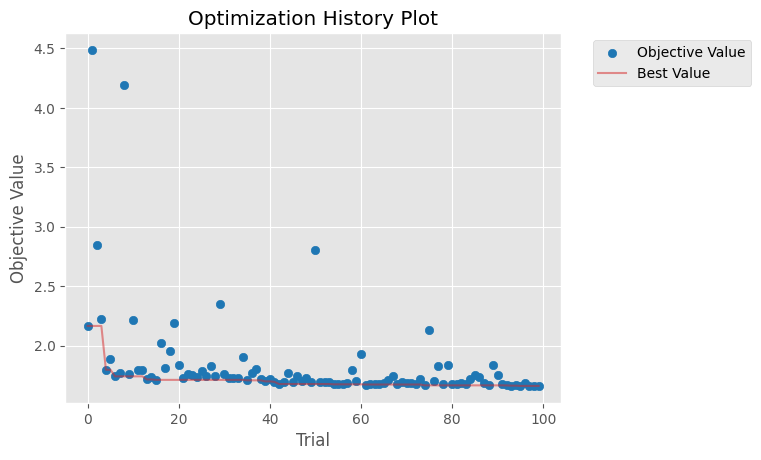

In [21]:
# Посмотрим на процесс подбора параметров на графике
plot_optimization_history(study_catb_reg)

In [35]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_catb_reg.trials)))
print('Лучший трайл:')
trial = study_catb_reg.best_trial

print('  Лучший MAE: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 100
Лучший трайл:
  Лучший MAE: 1.6605998234725894
  Параметры: 
    iterations: 971
    learning_rate: 0.09963006571699068
    depth: 10
    l2_leaf_reg: 1.2480966081890945e-06
    random_strength: 1.0894384781338137e-07
    bagging_temperature: 2.7793214315664803
    od_type: Iter
    od_wait: 10


In [36]:
# Засечем время, которое алгоритму потребуется на обучение
start_time = time.time()

# Обучим модель на получившихся параметрах
params = trial.params
catb_reg = CatBoostRegressor(verbose=0,**params)
catb_reg.fit(X_train_sc, y_train)

# Предсказание
y_pred_catb_reg = catb_reg.predict(X_test_sc)

# Конец временного промежутка
catb_reg_time = time.time() - start_time

# Считаем основные метрики
smlar_catb = smlar(y_test, y_pred_catb_reg)
mae_catb = mean_absolute_error(y_test, y_pred_catb_reg)
mse_catb = mean_squared_error(y_test, y_pred_catb_reg)
r2_catb = r2_score(y_test, y_pred_catb_reg)

# Выводим основные метрики
print(f"SMLAR CatBoost: {smlar_catb * 100 :.2f}%")
print(f"MAE CatBoost: {mae_catb:.3f}")
print(f"MSE CatBoost: {mse_catb:.3f}")
print(f"R2_score CatBoost: {r2_catb * 100 :.2f}%")
print(f"Время обучения CatBoost: {catb_reg_time:.2f} сек")

SMLAR CatBoost: 41.74%
MAE CatBoost: 1.661
MSE CatBoost: 5.906
R2_score CatBoost: 89.55%
Время обучения CatBoost: 162.69 сек


In [24]:
# вычисление SHAP-значений
explainer_catb = shap.Explainer(catb_reg)
shap_values_catb = explainer_catb(X_test)

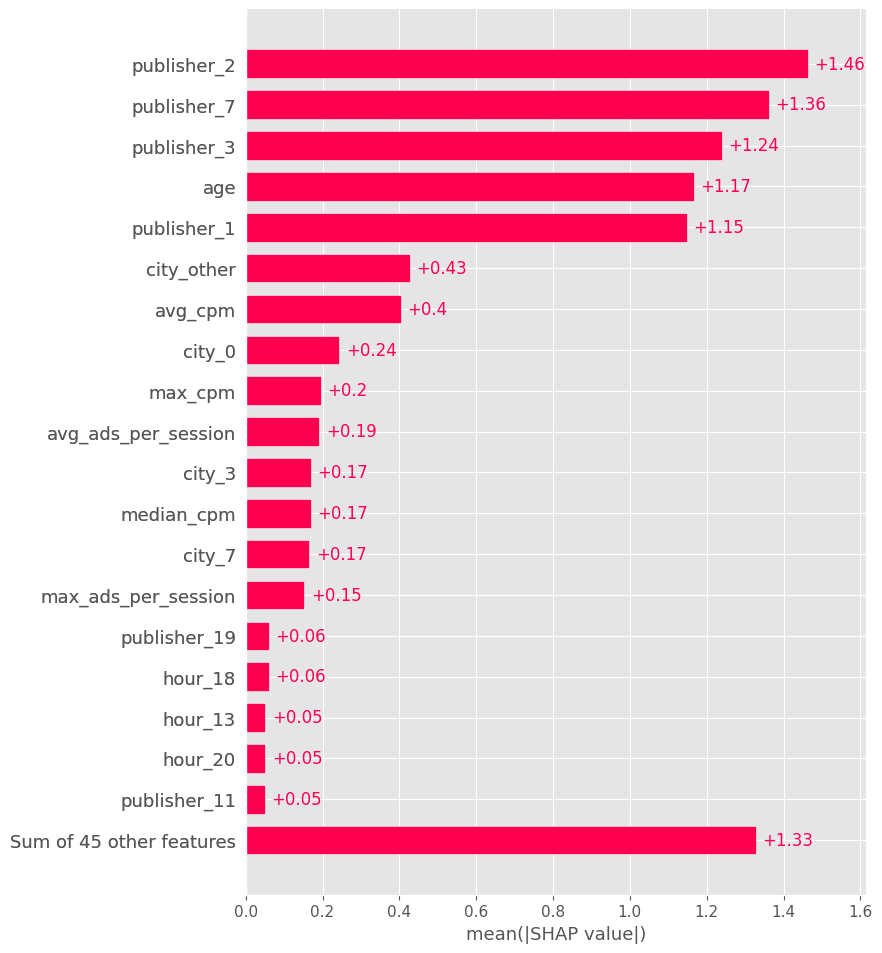

In [25]:
# определение признаков, являющихся наиболее важными для прогнозов
shap.plots.bar(shap_values_catb, max_display=20)

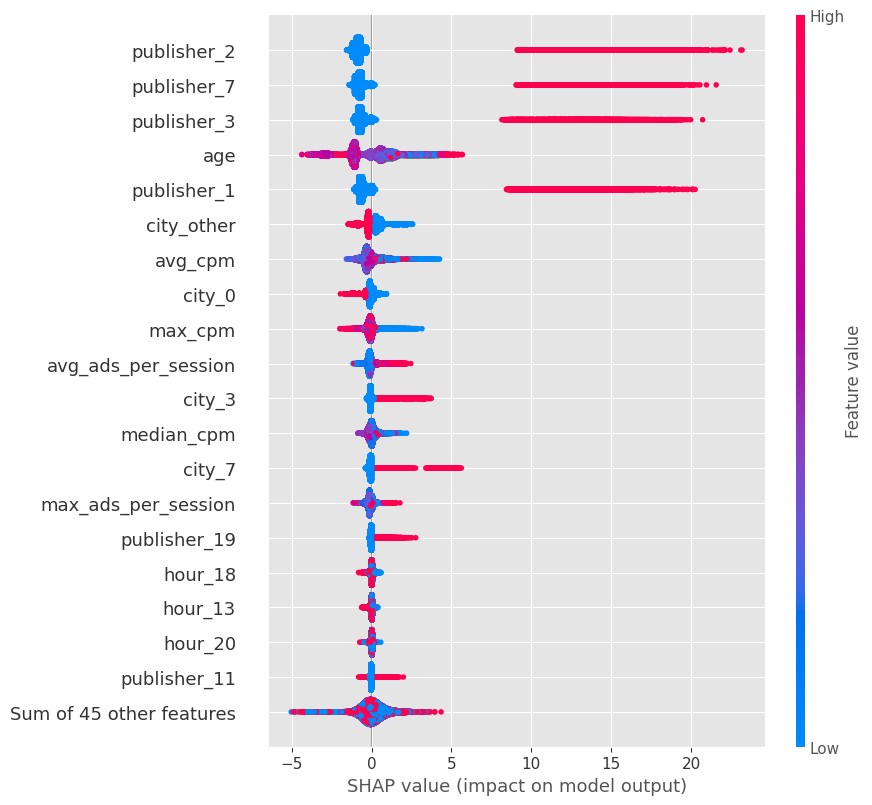

In [26]:
# визуализация всех SHAP‑значений для признаков
shap.plots.beeswarm(shap_values_catb, max_display=20)

In [37]:
# Сохраним модель
with open(r'models/catb_model.pkl', 'wb') as file:
    pickle.dump(catb_reg, file)
    
# Сохранение модели для google colab
# with open(r'/content/drive/MyDrive/Colab Notebooks/models/catb_model.pkl', 'wb') as file:
#     pickle.dump(catb_reg, file)

### <a id="43">XGBoost</a>

In [29]:
def objective_xgb_reg(trial):
    # Подбираемые параметры
    params={
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    # Обучаем модель
    optuna_model = XGBRegressor(**params)
    optuna_model.fit(X_train_sc, y_train)

    # Предсказание
    y_pred = optuna_model.predict(X_test_sc)

    # Оценка предсказания
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# Создаем сессию для минимизации выбранной метрики
study_xgb_reg = optuna.create_study(direction='minimize')
# Запускаем нашу сессию оптимизации
study_xgb_reg.optimize(objective_xgb_reg, n_trials=100)

[I 2024-12-17 10:56:50,203] A new study created in memory with name: no-name-af610e13-5f91-479b-aff7-79814530b2e4
[I 2024-12-17 10:57:03,567] Trial 0 finished with value: 1.986757516860962 and parameters: {'learning_rate': 0.04176520490474728, 'n_estimators': 207, 'max_depth': 4, 'subsample': 0.5847650738452885, 'colsample_bytree': 0.6043270410519356}. Best is trial 0 with value: 1.986757516860962.
[I 2024-12-17 10:57:46,989] Trial 1 finished with value: 1.64336359500885 and parameters: {'learning_rate': 0.19725891671126447, 'n_estimators': 676, 'max_depth': 7, 'subsample': 0.9967198795415148, 'colsample_bytree': 0.5539022911347319}. Best is trial 1 with value: 1.64336359500885.
[I 2024-12-17 10:58:51,532] Trial 2 finished with value: 1.6615945100784302 and parameters: {'learning_rate': 0.09776482381458587, 'n_estimators': 842, 'max_depth': 8, 'subsample': 0.5861459056912811, 'colsample_bytree': 0.7336818859761199}. Best is trial 1 with value: 1.64336359500885.
[I 2024-12-17 10:59:23,0

<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

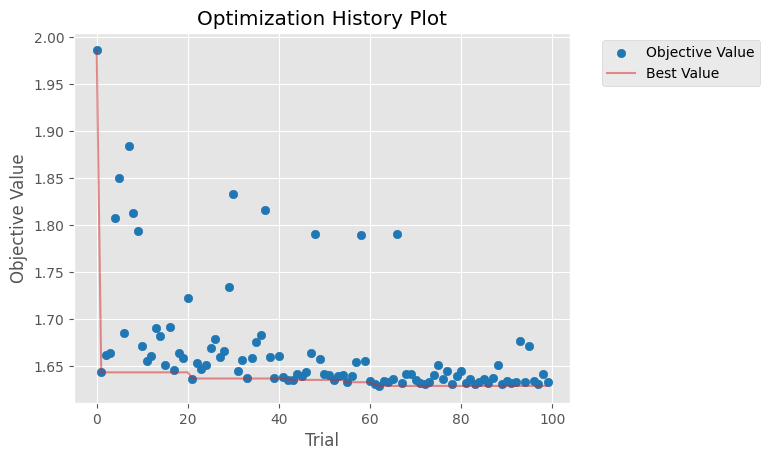

In [30]:
# Посмотрим на процесс подбора параметров на графике
plot_optimization_history(study_xgb_reg)

In [38]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_xgb_reg.trials)))
print('Лучший трайл:')
trial = study_xgb_reg.best_trial

print('  Лучший MAE: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 100
Лучший трайл:
  Лучший MAE: 1.6288982629776
  Параметры: 
    learning_rate: 0.11835528238549968
    n_estimators: 736
    max_depth: 9
    subsample: 0.9508779631722803
    colsample_bytree: 0.9990372826960315


In [39]:
# Засечем время, которое алгоритму потребуется на обучение
start_time = time.time()

# Обучим модель на получившихся параметрах
params = trial.params
xgb_reg = XGBRegressor(**params)
xgb_reg.fit(X_train_sc, y_train)

# Предсказание
y_pred_xgb_reg = xgb_reg.predict(X_test_sc)

# Конец временного промежутка
xgb_reg_time = time.time() - start_time

# Считаем основные метрики
smlar_xgb = smlar(y_test, y_pred_xgb_reg)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb_reg)
mse_xgb = mean_squared_error(y_test, y_pred_xgb_reg)
r2_xgb = r2_score(y_test, y_pred_xgb_reg)

# Выводим основные метрики
print(f"SMLAR XGBoost: {smlar_xgb * 100 :.2f}%")
print(f"MAE XGBoost: {mae_xgb:.3f}")
print(f"MSE XGBoost: {mse_xgb:.3f}")
print(f"R2_score XGBoost: {r2_xgb * 100 :.2f}%")
print(f"Время обучения LightGBM: {xgb_reg_time:.2f} сек")

SMLAR XGBoost: 41.15%
MAE XGBoost: 1.629
MSE XGBoost: 5.641
R2_score XGBoost: 90.02%
Время обучения LightGBM: 60.52 сек


In [ ]:
# вычисление SHAP-значений
explainer_xgb = shap.Explainer(xgb_reg)
shap_values_xgb = explainer_xgb(X_test)

In [ ]:
# определение признаков, являющихся наиболее важными для прогнозов
shap.plots.bar(shap_values_xgb, max_display=20)

In [ ]:
# визуализация всех SHAP‑значений для признаков
shap.plots.beeswarm(shap_values_xgb, max_display=20)

In [40]:
# Сохраним модель
with open(r'models/xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_reg, file)

# Сохранение для google colab
# with open(r'/content/drive/MyDrive/Colab Notebooks/models/xgb_model.pkl', 'wb') as file:
#     pickle.dump(xgb_reg, file)

### <a id="44">Сравнение моделей</a>

In [41]:
# Соберем основные метрики по моделям в одну таблицу
regression_df = pd.DataFrame(
    data = [
        [f'{mse_lgbm:.4f}', f'{mse_catb:.4f}', f'{mse_xgb:.4f}'],
        [f'{mae_lgbm:.4f}', f'{mae_catb:.4f}', f'{mae_xgb:.4f}'],
        [f'{r2_lgbm*100:.1f}%', f'{r2_catb*100:.1f}%', f'{r2_xgb*100:.1f}%'],
        [f'{smlar_lgbm*100:.1f}%', f'{smlar_catb*100:.1f}%', f'{smlar_xgb*100:.1f}%'],
        [f'{lgbm_reg_time:.2f} сек', f'{catb_reg_time:.2f} сек', f'{xgb_reg_time:.2f} сек']
    ],
    columns= ['LightGBM', 'CatBoost', 'XGBoost'],
    index = ['MSE', 'MAE', 'SMLAR', 'R2-score', 'Time']
)
display(regression_df)

,LightGBM,CatBoost,XGBoost
MSE,6.1540,5.9062,5.6410
MAE,1.6994,1.6606,1.6289
SMLAR,89.1%,89.5%,90.0%
R2-score,42.9%,41.7%,41.1%
Time,4.80 сек,162.69 сек,60.52 сек
